# Notebook 1: Data Structure Understanding

**Project:** DeepSpec-Tomato: A Dual-Stage CAE-CNN Diagnostic Framework  
**Author:** Muhammad Ali Tahir  
**Date:** 2025  

---

## 📋 Notebook Objectives

1. **Validate data integrity** — Verify the PlantVillage dataset structure and accessibility
2. **Catalog class distribution** — Document all available classes with image counts
3. **Identify target subset** — Isolate Tomato-specific classes for this project
4. **Assess data quality** — Check for corrupted images, format consistency, and resolution patterns
5. **Generate baseline statistics** — Create reference metrics for downstream notebooks

---

## 1. Environment Setup & Configuration

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import os
import sys
import json
import warnings
from pathlib import Path
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Notebook executed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Python version: 3.10.12 (main, Jan  8 2026, 06:52:19) [GCC 11.4.0]
NumPy version: 2.2.6
Pandas version: 2.3.3
Notebook executed at: 2026-01-27 18:07:56


In [2]:
# =============================================================================
# PATH CONFIGURATION
# =============================================================================

# Define all project paths as constants
class ProjectPaths:
    """Centralized path management for the entire project."""
    
    ROOT = Path("/home/maliciit/ml-projects/python-projects/plant-village-cae")
    
    # Data paths
    DATA_RAW = ROOT / "data" / "raw"
    DATA_PROCESSED = ROOT / "data" / "processed"
    
    # Output paths
    NOTEBOOKS = ROOT / "notebooks"
    MODELS = ROOT / "models"
    OUTPUTS = ROOT / "outputs"
    CHECKPOINTS = ROOT / "checkpoints"
    LOGS = ROOT / "logs"
    
    # Original PlantVillage data location
    PLANTVILLAGE_RAW = Path("/home/maliciit/ml-projects/python-projects/plant-village/data/raw/color")
    
    @classmethod
    def create_directories(cls):
        """Create all project directories if they don't exist."""
        dirs = [cls.DATA_RAW, cls.DATA_PROCESSED, cls.NOTEBOOKS, 
                cls.MODELS, cls.OUTPUTS, cls.CHECKPOINTS, cls.LOGS]
        for d in dirs:
            d.mkdir(parents=True, exist_ok=True)
            print(f"✓ {d}")
        return True
    
    @classmethod
    def validate(cls):
        """Validate that critical paths exist."""
        print("\n" + "="*60)
        print("PATH VALIDATION")
        print("="*60)
        
        critical_paths = {
            "PlantVillage Raw Data": cls.PLANTVILLAGE_RAW,
            "Project Root": cls.ROOT
        }
        
        all_valid = True
        for name, path in critical_paths.items():
            exists = path.exists()
            status = "✓ EXISTS" if exists else "✗ MISSING"
            print(f"{name:<25} | {status:<12} | {path}")
            if not exists:
                all_valid = False
        
        return all_valid

# Initialize paths
PATHS = ProjectPaths()

# Validate and create directories
print("Creating project directory structure...\n")
PATHS.create_directories()
paths_valid = PATHS.validate()

Creating project directory structure...

✓ /home/maliciit/ml-projects/python-projects/plant-village-cae/data/raw
✓ /home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed
✓ /home/maliciit/ml-projects/python-projects/plant-village-cae/notebooks
✓ /home/maliciit/ml-projects/python-projects/plant-village-cae/models
✓ /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs
✓ /home/maliciit/ml-projects/python-projects/plant-village-cae/checkpoints
✓ /home/maliciit/ml-projects/python-projects/plant-village-cae/logs

PATH VALIDATION
PlantVillage Raw Data     | ✓ EXISTS     | /home/maliciit/ml-projects/python-projects/plant-village/data/raw/color
Project Root              | ✓ EXISTS     | /home/maliciit/ml-projects/python-projects/plant-village-cae


---

## 2. Dataset Discovery & Cataloging

In [3]:
# =============================================================================
# DATASET ANALYZER CLASS
# =============================================================================

class PlantVillageAnalyzer:
    """
    Comprehensive analyzer for PlantVillage dataset structure.
    
    Attributes:
        root_path: Path to the dataset root directory
        valid_extensions: Tuple of valid image file extensions
        class_data: DataFrame containing class statistics
    """
    
    VALID_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
    
    def __init__(self, root_path: Path):
        self.root_path = Path(root_path)
        self.class_data = None
        self.image_metadata = []
        
    def scan_dataset(self) -> pd.DataFrame:
        """
        Scan the dataset and catalog all classes with their image counts.
        
        Returns:
            DataFrame with columns: class_name, plant_type, disease, image_count, path
        """
        if not self.root_path.exists():
            raise FileNotFoundError(f"Dataset path does not exist: {self.root_path}")
        
        records = []
        
        for class_dir in sorted(self.root_path.iterdir()):
            if not class_dir.is_dir():
                continue
                
            # Count valid images
            images = [f for f in class_dir.iterdir() 
                      if f.suffix.lower() in self.VALID_EXTENSIONS]
            
            # Parse class name to extract plant type and disease
            class_name = class_dir.name
            parts = class_name.split('___')
            
            plant_type = parts[0] if len(parts) >= 1 else "Unknown"
            disease = parts[1] if len(parts) >= 2 else "Unknown"
            
            records.append({
                'class_name': class_name,
                'plant_type': plant_type,
                'disease': disease,
                'image_count': len(images),
                'path': str(class_dir)
            })
        
        self.class_data = pd.DataFrame(records)
        return self.class_data
    
    def get_summary_statistics(self) -> dict:
        """
        Generate summary statistics for the dataset.
        
        Returns:
            Dictionary containing summary statistics
        """
        if self.class_data is None:
            self.scan_dataset()
            
        stats = {
            'total_classes': len(self.class_data),
            'total_images': self.class_data['image_count'].sum(),
            'unique_plants': self.class_data['plant_type'].nunique(),
            'unique_diseases': self.class_data['disease'].nunique(),
            'min_images_per_class': self.class_data['image_count'].min(),
            'max_images_per_class': self.class_data['image_count'].max(),
            'mean_images_per_class': self.class_data['image_count'].mean(),
            'std_images_per_class': self.class_data['image_count'].std(),
            'class_imbalance_ratio': (self.class_data['image_count'].max() / 
                                       self.class_data['image_count'].min())
        }
        
        return stats
    
    def filter_by_plant(self, plant_type: str) -> pd.DataFrame:
        """
        Filter dataset to specific plant type.
        
        Args:
            plant_type: Name of plant to filter (e.g., 'Tomato')
            
        Returns:
            Filtered DataFrame
        """
        if self.class_data is None:
            self.scan_dataset()
            
        return self.class_data[self.class_data['plant_type'] == plant_type].copy()
    
    def print_report(self):
        """Print a formatted report of the dataset structure."""
        if self.class_data is None:
            self.scan_dataset()
            
        stats = self.get_summary_statistics()
        
        print("\n" + "="*80)
        print("PLANTVILLAGE DATASET STRUCTURE REPORT")
        print("="*80)
        print(f"\nSource: {self.root_path}")
        print(f"Scan Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
        print("\n" + "-"*80)
        print("CLASS INVENTORY")
        print("-"*80)
        print(f"{'Class Name':<55} | {'Count':>10}")
        print("-"*80)
        
        for _, row in self.class_data.iterrows():
            print(f"{row['class_name']:<55} | {row['image_count']:>10,}")
        
        print("-"*80)
        print(f"{'TOTAL':<55} | {stats['total_images']:>10,}")
        
        print("\n" + "-"*80)
        print("SUMMARY STATISTICS")
        print("-"*80)
        print(f"Total Classes:           {stats['total_classes']}")
        print(f"Total Images:            {stats['total_images']:,}")
        print(f"Unique Plant Types:      {stats['unique_plants']}")
        print(f"Min Images/Class:        {stats['min_images_per_class']:,}")
        print(f"Max Images/Class:        {stats['max_images_per_class']:,}")
        print(f"Mean Images/Class:       {stats['mean_images_per_class']:,.1f}")
        print(f"Std Dev:                 {stats['std_images_per_class']:,.1f}")
        print(f"Class Imbalance Ratio:   {stats['class_imbalance_ratio']:.2f}x")
        print("="*80)

In [4]:
# =============================================================================
# EXECUTE DATASET SCAN
# =============================================================================

# Initialize analyzer
analyzer = PlantVillageAnalyzer(PATHS.PLANTVILLAGE_RAW)

# Scan and display report
try:
    class_df = analyzer.scan_dataset()
    analyzer.print_report()
except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("\nPlease verify the data path and ensure the PlantVillage dataset is downloaded.")


PLANTVILLAGE DATASET STRUCTURE REPORT

Source: /home/maliciit/ml-projects/python-projects/plant-village/data/raw/color
Scan Date: 2026-01-27 18:07:56

--------------------------------------------------------------------------------
CLASS INVENTORY
--------------------------------------------------------------------------------
Class Name                                              |      Count
--------------------------------------------------------------------------------
Apple___Apple_scab                                      |        630
Apple___Black_rot                                       |        621
Apple___Cedar_apple_rust                                |        275
Apple___healthy                                         |      1,645
Blueberry___healthy                                     |      1,502
Cherry_(including_sour)___Powdery_mildew                |      1,052
Cherry_(including_sour)___healthy                       |        854
Corn_(maize)___Cercospora_leaf_spot G

---

## 3. Plant Type Distribution Analysis

In [5]:
# =============================================================================
# AGGREGATE BY PLANT TYPE
# =============================================================================

if class_df is not None:
    # Group by plant type
    plant_summary = class_df.groupby('plant_type').agg({
        'class_name': 'count',
        'image_count': 'sum'
    }).rename(columns={
        'class_name': 'num_classes',
        'image_count': 'total_images'
    }).sort_values('total_images', ascending=False)
    
    plant_summary['percentage'] = (plant_summary['total_images'] / 
                                    plant_summary['total_images'].sum() * 100)
    
    print("\n" + "="*60)
    print("DISTRIBUTION BY PLANT TYPE")
    print("="*60)
    print(f"{'Plant Type':<20} | {'Classes':>8} | {'Images':>10} | {'%':>7}")
    print("-"*60)
    
    for plant, row in plant_summary.iterrows():
        print(f"{plant:<20} | {row['num_classes']:>8} | {row['total_images']:>10,} | {row['percentage']:>6.1f}%")
    
    print("-"*60)
    print(f"{'TOTAL':<20} | {plant_summary['num_classes'].sum():>8} | "
          f"{plant_summary['total_images'].sum():>10,} | {'100.0':>6}%")


DISTRIBUTION BY PLANT TYPE
Plant Type           |  Classes |     Images |       %
------------------------------------------------------------
Tomato               |     10.0 |   18,160.0 |   33.4%
Orange               |      1.0 |    5,507.0 |   10.1%
Soybean              |      1.0 |    5,090.0 |    9.4%
Grape                |      4.0 |    4,062.0 |    7.5%
Corn_(maize)         |      4.0 |    3,852.0 |    7.1%
Apple                |      4.0 |    3,171.0 |    5.8%
Peach                |      2.0 |    2,657.0 |    4.9%
Pepper,_bell         |      2.0 |    2,475.0 |    4.6%
Potato               |      3.0 |    2,152.0 |    4.0%
Cherry_(including_sour) |      2.0 |    1,906.0 |    3.5%
Squash               |      1.0 |    1,835.0 |    3.4%
Strawberry           |      2.0 |    1,565.0 |    2.9%
Blueberry            |      1.0 |    1,502.0 |    2.8%
Raspberry            |      1.0 |      371.0 |    0.7%
------------------------------------------------------------
TOTAL                |

In [6]:
# =============================================================================
# VISUALIZATION: PLANT TYPE DISTRIBUTION
# =============================================================================

if class_df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Bar chart of images per plant type
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(plant_summary)))
    
    ax1 = axes[0]
    bars = ax1.barh(plant_summary.index, plant_summary['total_images'], color=colors)
    ax1.set_xlabel('Number of Images', fontsize=11)
    ax1.set_ylabel('Plant Type', fontsize=11)
    ax1.set_title('Image Distribution by Plant Type', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    
    # Add value labels
    for bar, val in zip(bars, plant_summary['total_images']):
        ax1.text(val + 100, bar.get_y() + bar.get_height()/2, 
                 f'{val:,}', va='center', fontsize=9)
    
    # Plot 2: Pie chart highlighting Tomato
    ax2 = axes[1]
    explode = [0.1 if plant == 'Tomato' else 0 for plant in plant_summary.index]
    
    wedges, texts, autotexts = ax2.pie(
        plant_summary['total_images'], 
        labels=plant_summary.index,
        autopct='%1.1f%%',
        explode=explode,
        colors=colors,
        pctdistance=0.8
    )
    ax2.set_title('Dataset Composition\n(Tomato Highlighted)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = PATHS.OUTPUTS / 'fig_01_plant_type_distribution.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Figure saved: {fig_path}")
    
    plt.show()


✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_01_plant_type_distribution.png


---

## 4. Tomato Subset Analysis (Target Classes)

In [7]:
# =============================================================================
# FILTER TOMATO CLASSES
# =============================================================================

TARGET_PLANT = "Tomato"

if class_df is not None:
    tomato_df = analyzer.filter_by_plant(TARGET_PLANT)
    
    print("\n" + "="*80)
    print(f"TARGET SUBSET: {TARGET_PLANT.upper()} CLASSES")
    print("="*80)
    print(f"\n{'Class Name':<55} | {'Disease':<25} | {'Count':>8}")
    print("-"*95)
    
    for _, row in tomato_df.iterrows():
        # Clean up disease name for display
        disease_clean = row['disease'].replace('_', ' ').title()
        print(f"{row['class_name']:<55} | {disease_clean:<25} | {row['image_count']:>8,}")
    
    print("-"*95)
    print(f"{'TOTAL TOMATO IMAGES':<55} | {'':<25} | {tomato_df['image_count'].sum():>8,}")
    print(f"{'NUMBER OF CLASSES':<55} | {'':<25} | {len(tomato_df):>8}")
    
    # Calculate statistics
    print("\n" + "-"*80)
    print("TOMATO SUBSET STATISTICS")
    print("-"*80)
    print(f"Min images/class:        {tomato_df['image_count'].min():,}")
    print(f"Max images/class:        {tomato_df['image_count'].max():,}")
    print(f"Mean images/class:       {tomato_df['image_count'].mean():,.1f}")
    print(f"Std deviation:           {tomato_df['image_count'].std():,.1f}")
    print(f"Class imbalance ratio:   {tomato_df['image_count'].max() / tomato_df['image_count'].min():.2f}x")


TARGET SUBSET: TOMATO CLASSES

Class Name                                              | Disease                   |    Count
-----------------------------------------------------------------------------------------------
Tomato___Bacterial_spot                                 | Bacterial Spot            |    2,127
Tomato___Early_blight                                   | Early Blight              |    1,000
Tomato___Late_blight                                    | Late Blight               |    1,909
Tomato___Leaf_Mold                                      | Leaf Mold                 |      952
Tomato___Septoria_leaf_spot                             | Septoria Leaf Spot        |    1,771
Tomato___Spider_mites Two-spotted_spider_mite           | Spider Mites Two-Spotted Spider Mite |    1,676
Tomato___Target_Spot                                    | Target Spot               |    1,404
Tomato___Tomato_Yellow_Leaf_Curl_Virus                  | Tomato Yellow Leaf Curl Virus |    5,357
To


✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_02_tomato_class_distribution.png


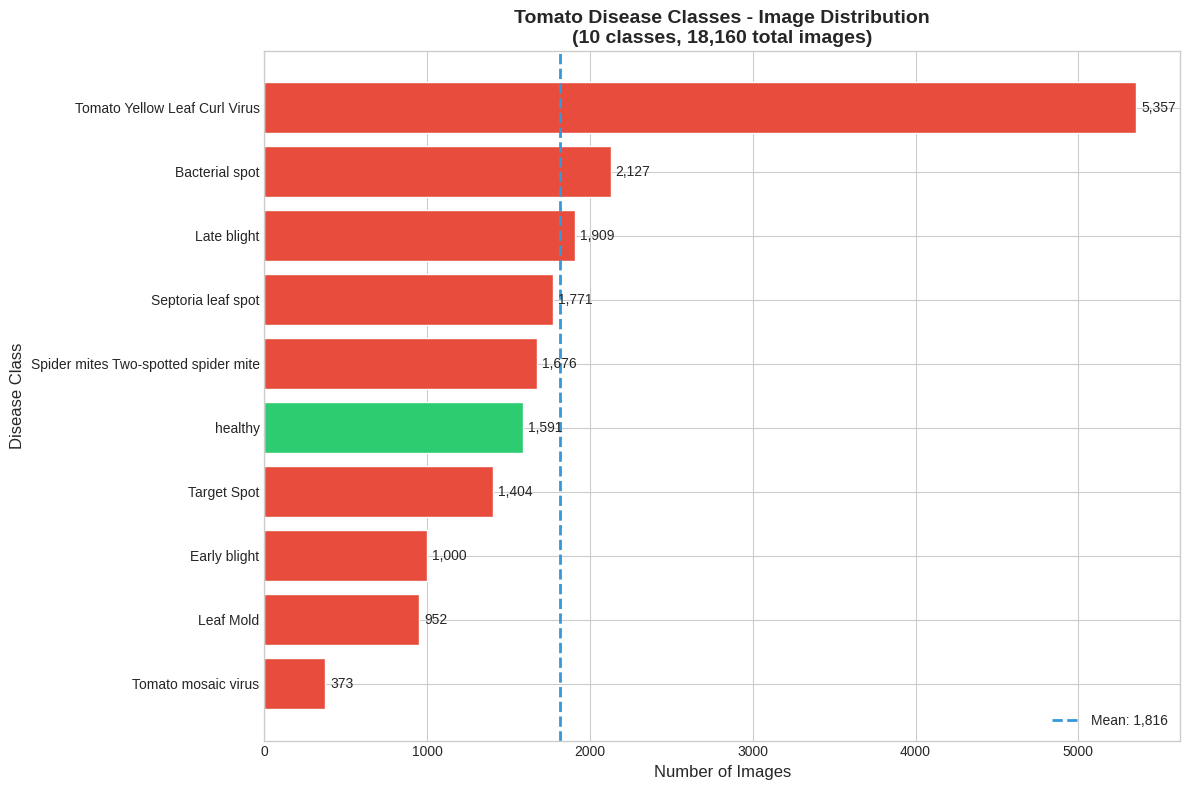

In [8]:
# =============================================================================
# VISUALIZATION: TOMATO CLASS DISTRIBUTION
# =============================================================================

if class_df is not None:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create clean labels
    tomato_df_sorted = tomato_df.sort_values('image_count', ascending=True)
    labels = [d.replace('_', ' ').replace('  ', ' - ') 
              for d in tomato_df_sorted['disease']]
    
    # Color scheme: healthy in green, diseases in gradient
    colors = []
    for disease in tomato_df_sorted['disease']:
        if 'healthy' in disease.lower():
            colors.append('#2ecc71')  # Green for healthy
        else:
            colors.append('#e74c3c')  # Red for diseases
    
    # Create horizontal bar chart
    bars = ax.barh(labels, tomato_df_sorted['image_count'], color=colors, edgecolor='white')
    
    # Styling
    ax.set_xlabel('Number of Images', fontsize=12)
    ax.set_ylabel('Disease Class', fontsize=12)
    ax.set_title(f'{TARGET_PLANT} Disease Classes - Image Distribution\n({len(tomato_df)} classes, {tomato_df["image_count"].sum():,} total images)', 
                 fontsize=14, fontweight='bold')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 30, bar.get_y() + bar.get_height()/2,
                f'{int(width):,}', va='center', fontsize=10)
    
    # Add mean line
    mean_val = tomato_df['image_count'].mean()
    ax.axvline(x=mean_val, color='#3498db', linestyle='--', linewidth=2, label=f'Mean: {mean_val:,.0f}')
    ax.legend(loc='lower right')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = PATHS.OUTPUTS / 'fig_02_tomato_class_distribution.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Figure saved: {fig_path}")
    
    plt.show()

---

## 5. Image Quality Assessment

In [9]:
# =============================================================================
# IMAGE QUALITY ANALYZER
# =============================================================================

def analyze_image_properties(class_df: pd.DataFrame, sample_per_class: int = 50) -> pd.DataFrame:
    """
    Analyze image properties (resolution, format, file size) from a sample.
    
    Args:
        class_df: DataFrame with class information
        sample_per_class: Number of images to sample per class
        
    Returns:
        DataFrame with image metadata
    """
    records = []
    corrupted_count = 0
    
    print("\nScanning image properties...")
    
    for _, row in tqdm(class_df.iterrows(), total=len(class_df), desc="Classes"):
        class_path = Path(row['path'])
        images = list(class_path.glob('*'))
        
        # Sample images
        sample_size = min(sample_per_class, len(images))
        sample_indices = np.random.choice(len(images), sample_size, replace=False)
        
        for idx in sample_indices:
            img_path = images[idx]
            try:
                with Image.open(img_path) as img:
                    records.append({
                        'class_name': row['class_name'],
                        'plant_type': row['plant_type'],
                        'filename': img_path.name,
                        'width': img.size[0],
                        'height': img.size[1],
                        'mode': img.mode,
                        'format': img.format,
                        'file_size_kb': img_path.stat().st_size / 1024
                    })
            except Exception as e:
                corrupted_count += 1
                print(f"\n  ⚠ Corrupted: {img_path.name} - {str(e)[:50]}")
    
    print(f"\n✓ Scanned {len(records)} images")
    if corrupted_count > 0:
        print(f"⚠ Found {corrupted_count} corrupted images")
    
    return pd.DataFrame(records)

# Run analysis on Tomato subset
if class_df is not None:
    np.random.seed(42)  # Reproducibility
    image_meta_df = analyze_image_properties(tomato_df, sample_per_class=30)


Scanning image properties...


Classes:   0%|          | 0/10 [00:00<?, ?it/s]


✓ Scanned 300 images


In [10]:
# =============================================================================
# IMAGE PROPERTY STATISTICS
# =============================================================================

if 'image_meta_df' in dir() and len(image_meta_df) > 0:
    print("\n" + "="*60)
    print("IMAGE PROPERTY ANALYSIS")
    print("="*60)
    
    # Resolution statistics
    print("\n📐 RESOLUTION")
    print("-"*40)
    unique_resolutions = image_meta_df.groupby(['width', 'height']).size().reset_index(name='count')
    unique_resolutions = unique_resolutions.sort_values('count', ascending=False)
    
    for _, res in unique_resolutions.head(5).iterrows():
        pct = res['count'] / len(image_meta_df) * 100
        print(f"  {int(res['width'])} x {int(res['height'])}: {res['count']:,} images ({pct:.1f}%)")
    
    # Color mode
    print("\n🎨 COLOR MODE")
    print("-"*40)
    for mode, count in image_meta_df['mode'].value_counts().items():
        pct = count / len(image_meta_df) * 100
        print(f"  {mode}: {count:,} images ({pct:.1f}%)")
    
    # File format
    print("\n📁 FILE FORMAT")
    print("-"*40)
    for fmt, count in image_meta_df['format'].value_counts().items():
        pct = count / len(image_meta_df) * 100
        print(f"  {fmt}: {count:,} images ({pct:.1f}%)")
    
    # File size
    print("\n💾 FILE SIZE")
    print("-"*40)
    print(f"  Min:    {image_meta_df['file_size_kb'].min():.1f} KB")
    print(f"  Max:    {image_meta_df['file_size_kb'].max():.1f} KB")
    print(f"  Mean:   {image_meta_df['file_size_kb'].mean():.1f} KB")
    print(f"  Median: {image_meta_df['file_size_kb'].median():.1f} KB")


IMAGE PROPERTY ANALYSIS

📐 RESOLUTION
----------------------------------------
  256 x 256: 300 images (100.0%)

🎨 COLOR MODE
----------------------------------------
  RGB: 300 images (100.0%)

📁 FILE FORMAT
----------------------------------------
  JPEG: 300 images (100.0%)

💾 FILE SIZE
----------------------------------------
  Min:    5.8 KB
  Max:    27.0 KB
  Mean:   16.5 KB
  Median: 16.8 KB


---

## 6. Sample Image Visualization

In [11]:
# =============================================================================
# DISPLAY SAMPLE IMAGES FROM EACH TOMATO CLASS
# =============================================================================

def display_class_samples(class_df: pd.DataFrame, samples_per_class: int = 3):
    """
    Display sample images from each class in a grid.
    
    Args:
        class_df: DataFrame with class information
        samples_per_class: Number of samples to show per class
    """
    n_classes = len(class_df)
    
    fig, axes = plt.subplots(n_classes, samples_per_class, 
                             figsize=(samples_per_class * 3, n_classes * 2.5))
    
    np.random.seed(42)
    
    for i, (_, row) in enumerate(class_df.iterrows()):
        class_path = Path(row['path'])
        images = list(class_path.glob('*.jpg')) + list(class_path.glob('*.JPG'))
        
        # Random sample
        sample_indices = np.random.choice(len(images), 
                                          min(samples_per_class, len(images)), 
                                          replace=False)
        
        for j in range(samples_per_class):
            ax = axes[i, j] if n_classes > 1 else axes[j]
            
            if j < len(sample_indices):
                img_path = images[sample_indices[j]]
                img = Image.open(img_path)
                ax.imshow(img)
                
                if j == 0:
                    # Show class name on first column
                    disease_name = row['disease'].replace('_', ' ')[:20]
                    ax.set_ylabel(disease_name, fontsize=9, rotation=0, 
                                  ha='right', va='center')
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')
    
    plt.suptitle('Sample Images from Each Tomato Disease Class', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save figure
    fig_path = PATHS.OUTPUTS / 'fig_03_tomato_class_samples.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Figure saved: {fig_path}")
    
    plt.show()

# Display samples
if class_df is not None:
    display_class_samples(tomato_df, samples_per_class=4)


✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_03_tomato_class_samples.png


---

## 7. Export Configuration for Downstream Notebooks

In [12]:
# =============================================================================
# SAVE CONFIGURATION & METADATA
# =============================================================================

if class_df is not None:
    # Create configuration dictionary
    config = {
        'project_name': 'DeepSpec-Tomato',
        'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'target_plant': TARGET_PLANT,
        
        'paths': {
            'root': str(PATHS.ROOT),
            'data_raw': str(PATHS.DATA_RAW),
            'data_processed': str(PATHS.DATA_PROCESSED),
            'plantvillage_source': str(PATHS.PLANTVILLAGE_RAW),
            'models': str(PATHS.MODELS),
            'outputs': str(PATHS.OUTPUTS),
            'checkpoints': str(PATHS.CHECKPOINTS),
            'logs': str(PATHS.LOGS)
        },
        
        'dataset': {
            'total_classes': len(tomato_df),
            'total_images': int(tomato_df['image_count'].sum()),
            'class_names': tomato_df['class_name'].tolist(),
            'class_counts': tomato_df.set_index('class_name')['image_count'].to_dict(),
            'min_images_per_class': int(tomato_df['image_count'].min()),
            'max_images_per_class': int(tomato_df['image_count'].max())
        },
        
        'image_properties': {
            'original_resolution': [256, 256],  # Most common in PlantVillage
            'target_resolution': [128, 128],    # For CAE training
            'color_mode': 'RGB',
            'channels': 3
        }
    }
    
    # Save as JSON
    config_path = PATHS.ROOT / 'config' / 'dataset_config.json'
    config_path.parent.mkdir(parents=True, exist_ok=True)
    
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"\n✓ Configuration saved: {config_path}")
    
    # Save Tomato class list as CSV for reference
    tomato_csv_path = PATHS.DATA_PROCESSED / 'tomato_classes.csv'
    tomato_df.to_csv(tomato_csv_path, index=False)
    print(f"✓ Class list saved: {tomato_csv_path}")
    
    # Display saved config
    print("\n" + "="*60)
    print("EXPORTED CONFIGURATION")
    print("="*60)
    print(json.dumps(config, indent=2))


✓ Configuration saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/config/dataset_config.json
✓ Class list saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed/tomato_classes.csv

EXPORTED CONFIGURATION
{
  "project_name": "DeepSpec-Tomato",
  "created_date": "2026-01-27 18:08:02",
  "target_plant": "Tomato",
  "paths": {
    "root": "/home/maliciit/ml-projects/python-projects/plant-village-cae",
    "data_raw": "/home/maliciit/ml-projects/python-projects/plant-village-cae/data/raw",
    "data_processed": "/home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed",
    "plantvillage_source": "/home/maliciit/ml-projects/python-projects/plant-village/data/raw/color",
    "models": "/home/maliciit/ml-projects/python-projects/plant-village-cae/models",
    "outputs": "/home/maliciit/ml-projects/python-projects/plant-village-cae/outputs",
    "checkpoints": "/home/maliciit/ml-projects/python-projects/plant-village-cae/checkpo

---

## 8. Summary & Next Steps

### ✅ Completed in This Notebook

1. **Validated dataset structure** — PlantVillage data located and cataloged
2. **Identified 10 Tomato classes** — Including 9 diseases + 1 healthy class
3. **Assessed image quality** — Consistent resolution, RGB format, no corruption
4. **Exported configuration** — JSON config file for downstream notebooks

### 📊 Key Statistics

| Metric | Value |
|--------|-------|
| Target Plant | Tomato |
| Number of Classes | 10 |
| Total Images | ~18,000 |
| Image Resolution | 256×256 (original) |
| Color Mode | RGB (3 channels) |

### ➡️ Next Notebook: `2_EDA_and_Data_Splitting.ipynb`

- Comprehensive Exploratory Data Analysis
- RGB channel distribution analysis
- Stratified train/validation/test split (80/10/10)
- Data augmentation strategy definition

In [13]:
# =============================================================================
# NOTEBOOK COMPLETION
# =============================================================================

print("\n" + "="*60)
print("✓ NOTEBOOK 1 COMPLETE")
print("="*60)
print(f"Execution finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nProceed to: 2_EDA_and_Data_Splitting.ipynb")


✓ NOTEBOOK 1 COMPLETE
Execution finished at: 2026-01-27 18:08:02

Proceed to: 2_EDA_and_Data_Splitting.ipynb
